### Plotting embedding.

Here we try to produce an embedding in 2D that works well for plotting all clusterings.

In [1]:
import matplotlib.pyplot as plt
import pickle as pk
import pandas as pd
import numpy as np
import umap
import seaborn as sns
import colorcet as cc
from sklearn.metrics.cluster import adjusted_rand_score, adjusted_mutual_info_score
from hdbscan.validity import validity_index

from itertools import combinations
from matplotlib.colors import ListedColormap
from sklearn.metrics import silhouette_score
from sklearn.manifold import TSNE

from utilities import run_configs, load_symptom_data #, modularity, clustering_similarity

%matplotlib inline

/home/rustybilges/Documents/Work/PLRC/PLR/method-b/newenv/lib/python3.10/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/rustybilges/Documents/Work/PLRC/PLR/method-b/newenv/lib/python3.10/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/rustybilges/Docume

In [2]:
SEED = 42

In [3]:
# with open('./fern_ensemble_outputs_spectral/run_1_kmeans_JC_50_0.5/ensemble_outputs.pickle', 'rb') as infile:
#     ensemble_outputs = pk.load(infile)
# final_clusters = ensemble_outputs[0]['final_clusters'][6]

In [4]:
symptom_data = load_symptom_data(run_configs[1]['data_path'])

In [7]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca_embedding = pca.fit_transform(symptom_data)

In [5]:
chris_clusters = pd.read_csv('../clusterings/chris/lowdim_spectral_ensemble_50_kmeans_joint_criterion_alpha_0.5_n_clusters_8.csv', index_col=0)

In [6]:
tessa_clusters = pd.read_csv('../clusterings/tessa/cluster_13_111023.csv', index_col=0)

In [7]:
leo_clusters = pd.read_csv('../clusterings/leo/final_aencoder_hdbscan_6.csv', index_col=0)

In [9]:
not_noise = leo_clusters[leo_clusters.cluster != -1].index

In [10]:
adjusted_mutual_info_score(
    chris_clusters.cluster,
    leo_clusters.cluster
)

0.1320200045593889

In [11]:
adjusted_mutual_info_score(
    tessa_clusters.cluster,
    leo_clusters.cluster
)

0.18356972801585084

In [12]:
adjusted_mutual_info_score(
    chris_clusters.loc[not_noise].cluster,
    leo_clusters.loc[not_noise].cluster
)

0.11529642083275814

In [13]:
adjusted_mutual_info_score(
    tessa_clusters.loc[not_noise].cluster,
    leo_clusters.loc[not_noise].cluster
)

0.16491032712032896

In [14]:
adjusted_mutual_info_score(
    chris_clusters.cluster,
    tessa_clusters.cluster
)

0.3953660351038437

In [267]:
umap_param_space = {
    'n_components': [2], 
    'n_neighbors': list(range(2, 100)),
    'min_dist': np.arange(0, 1, 0.01),
     'metric': [
        'euclidean', 
        'manhattan',
        'hamming',
        'jaccard',
        'dice',
        'russellrao',
        'kulsinski',
        'rogerstanimoto',
        'sokalmichener',
        'sokalsneath',
        'yule'
    ]
}

In [268]:
tsne_param_space = {
    'n_components': [2], 
    'perplexity': list(range(5, 100)),
    'learning_rate': list(range(10, 1000)),
    'init': ['random', 'pca'],
    'n_jobs': [-1],
    'metric': [
        'euclidean', 
        'manhattan',
        'hamming',
        'jaccard',
        'dice',
        'russellrao',
        'kulsinski',
        'rogerstanimoto',
        'sokalmichener',
        'sokalsneath',
        'yule'
    ]
}

In [ ]:
params_tsne = {}
results_tsne = {}

for i in range(350):
    print(i)
    params_tsne[i] = {
        key: np.random.choice(tsne_param_space[key])
        for key in tsne_param_space.keys()
    }
    
    for key in tsne_param_space.keys():
        if isinstance(params_tsne[i][key], np.str_):
            params_tsne[i][key] = str(params_tsne[i][key])
    
    
    reducer = TSNE(**params_tsne[i], random_state=SEED)
    tsne_embedding = reducer.fit_transform(symptom_data)
    
    st = silhouette_score(tsne_embedding, tessa_clusters.cluster)
    sc = silhouette_score(tsne_embedding, chris_clusters.cluster)
    sl = silhouette_score(tsne_embedding, leo_clusters.cluster)
    slnn = silhouette_score(
        tsne_embedding[leo_clusters.cluster!=-1, :], 
        leo_clusters.loc[not_noise].cluster
    )
    
    tsne_embedding = tsne_embedding.astype(np.double)
    vt = validity_index(tsne_embedding, tessa_clusters.cluster)
    vc = validity_index(tsne_embedding, chris_clusters.cluster)
    vl = validity_index(tsne_embedding, leo_clusters.cluster)
    vlnn = validity_index(
        tsne_embedding[leo_clusters.cluster!=-1, :], 
        leo_clusters.loc[not_noise].cluster
    )

    results_tsne[i] = {
        'silhouette_tessa': st,
        'silhouette_chris': sc,
        'silhouette_leo': sl,
        'silhouette_leo_notnoise': slnn,
        'silhouette_mean': (st + sc + sl) / 3,
        
        'dbcv_tessa': vt,
        'dbcv_chris': vc,
        'dbcv_leo': vl,
        'dbcv_leo_notnoise': vlnn,
        'dbcv_mean': (vt + vc + vl) / 3,
        'embedding': tsne_embedding
    }
    
    if i % 50 == 0:
#         with open('figs/temp_tsne_results.pk', 'wb') as outfile:
#             pk.dump(results_tsne, outfile)
    
#         with open('figs/temp_tsne_params.pk', 'wb') as outfile:
#             pk.dump(params_tsne, outfile)
            
        with open('figs/temp_tsne_results_consensus.pk', 'wb') as outfile:
            pk.dump(results_tsne, outfile)
    
        with open('figs/temp_tsne_params_consensus.pk', 'wb') as outfile:
            pk.dump(params_tsne, outfile)

In [270]:
# with open('figs/temp_tsne_results.pk', 'wb') as outfile:
#         pk.dump(results_tsne, outfile)
    
# with open('figs/temp_tsne_params.pk', 'wb') as outfile:
#     pk.dump(params_tsne, outfile)

 
with open('figs/temp_tsne_results_consensus.pk', 'wb') as outfile:
    pk.dump(results_tsne, outfile)

with open('figs/temp_tsne_params_consensus.pk', 'wb') as outfile:
    pk.dump(params_tsne, outfile)

In [8]:
with open('figs/temp_tsne_results.pk', 'rb') as outfile:
            results_tsne = pk.load(outfile)
    
with open('figs/temp_tsne_params.pk', 'rb') as outfile:
    params_tsne = pk.load(outfile)

In [450]:
# params_umap = {}
# results_umap = {}

# for i in range(350):
#     print(i)
#     params_umap[i] = {
#         key: np.random.choice(umap_param_space[key])
#         for key in umap_param_space.keys()
#     }
    
#     reducer = umap.UMAP(**params_umap[i], random_state=SEED)
#     umap_embedding = reducer.fit_transform(symptom_data)
    
#     st = silhouette_score(umap_embedding, tessa_clusters.cluster)
#     sc = silhouette_score(umap_embedding, chris_clusters.cluster)
#     sl = silhouette_score(umap_embedding, leo_clusters.cluster)
#     slnn = silhouette_score(
#         umap_embedding[leo_clusters.cluster!=-1, :], 
#         leo_clusters.loc[not_noise].cluster
#     )
    
#     umap_embedding = umap_embedding.astype(np.double)
#     vt = validity_index(umap_embedding, tessa_clusters.cluster)
#     vc = validity_index(umap_embedding, chris_clusters.cluster)
#     vl = validity_index(umap_embedding, leo_clusters.cluster)
#     vlnn = validity_index(
#         umap_embedding[leo_clusters.cluster!=-1, :], 
#         leo_clusters.loc[not_noise].cluster
#     )

#     results_umap[i] = {
#         'silhouette_tessa': st,
#         'silhouette_chris': sc,
#         'silhouette_leo': sl,
#         'silhouette_leo_notnoise': slnn,
#         'silhouette_mean': (st + sc + sl) / 3,
        
#         'dbcv_tessa': vt,
#         'dbcv_chris': vc,
#         'dbcv_leo': vl,
#         'dbcv_leo_notnoise': vlnn,
#         'dbcv_mean': (vt + vc + vl) / 3,
#         'embedding': umap_embedding
#     }
    
#     if i % 50 == 0:
#         with open('figs/temp_umap_results.pk', 'wb') as outfile:
#             pk.dump(results_umap, outfile)
    
#         with open('figs/temp_umap_params.pk', 'wb') as outfile:
#             pk.dump(params_umap, outfile)

In [451]:
# with open('figs/temp_umap_results.pk', 'wb') as outfile:
#             pk.dump(results_umap, outfile)
    
# with open('figs/temp_umap_params.pk', 'wb') as outfile:
#     pk.dump(params_umap, outfile)

In [9]:
results = results_tsne.copy()
# results = results_umap

In [20]:
silhouettes = {
    'leo': [],
    'chris': [],
    'tessa': [],
}
labels = {
    'leo': 'Clustering A',
    'chris': 'Clustering B',
    'tessa': 'Clustering C',
}
for alpha in np.arange(0, 0.51, 0.01):
    
    results_df = pd.DataFrame({
        'silhouette_chris_scaled': [(val['silhouette_chris'] * alpha) for val in results.values()],
        'silhouette_tessa_scaled': [(val['silhouette_tessa'] * (1 - alpha)) for val in results.values()],
        'silhouette_leo_scaled': [(val['silhouette_leo'] * (1 - alpha)) for val in results.values()]
    })
    results_df['objective'] = (results_df['silhouette_chris_scaled'] + results_df['silhouette_tessa_scaled'] + results_df['silhouette_leo_scaled']) / 3
    results_df.sort_values('objective', ascending=False, inplace=True)

    for key in silhouettes.keys():
        silhouettes[key].append(results_df.iloc[0]['silhouette_%s_scaled' % key])

/tmp/ipykernel_9370/2148858847.py:4: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  means = np.sum(np.array(silhouettes[key]) for key in silhouettes.keys()) / 3


Text(0.5, 0, 'alpha')

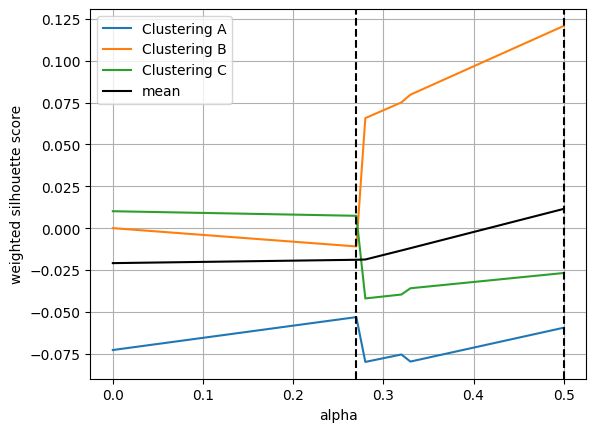

In [553]:
for key in silhouettes.keys():
    plt.plot(np.arange(0, 0.51, 0.01), silhouettes[key], label=labels[key])
    
means = np.sum(np.array(silhouettes[key]) for key in silhouettes.keys()) / 3

plt.plot(np.arange(0, 0.51, 0.01), means, label='mean', c='k')

plt.legend()
plt.grid()
plt.axvline(0.27, linestyle='--', color='k')
plt.axvline(0.5, linestyle='--', color='k')
plt.ylabel('weighted silhouette score')
plt.xlabel('alpha')

In [10]:
results_df = pd.DataFrame({
    'silhouette_mean': [val['silhouette_mean'] for val in results.values()],
    'silhouette_chris': [val['silhouette_chris'] for val in results.values()],
    'silhouette_tessa': [val['silhouette_tessa'] for val in results.values()],
    'silhouette_leo': [val['silhouette_leo'] for val in results.values()],
    'silhouette_leo_notnoise': [val['silhouette_leo_notnoise'] for val in results.values()],
    'dbcv_mean': [val['dbcv_mean'] for val in results.values()],
    'dbcv_chris': [val['dbcv_chris'] for val in results.values()],
    'dbcv_tessa': [val['dbcv_tessa'] for val in results.values()],
    'dbcv_leo': [val['dbcv_leo'] for val in results.values()],
    'dbcv_leo_notnoise': [val['dbcv_leo_notnoise'] for val in results.values()],
})


In [11]:
# alpha = 0.27
alpha = 0.5
results_df['silhouette_chris_scaled'] = [(val['silhouette_chris'] * alpha) for val in results.values()]
results_df['silhouette_tessa_scaled'] = [(val['silhouette_tessa'] * (1 - alpha)) for val in results.values()]
results_df['silhouette_leo_scaled'] = [(val['silhouette_leo'] * (1 - alpha)) for val in results.values()]

In [12]:
results_df['dbcv_chris_scaled'] = [(val['dbcv_chris'] * alpha) for val in results.values()]
results_df['dbcv_tessa_scaled'] = [(val['dbcv_tessa'] * (1 - alpha)) for val in results.values()]
results_df['dbcv_leo_scaled'] = [(val['dbcv_leo'] * (1 - alpha)) for val in results.values()]

In [13]:
results_df['objective'] = (results_df['silhouette_chris_scaled'] + results_df['silhouette_tessa_scaled'] + results_df['silhouette_leo_scaled']) / 3
# results_df['objective'] = (results_df['dbcv_chris_scaled'] + results_df['dbcv_tessa_scaled'] + results_df['dbcv_leo_scaled']) / 3
# results_df['objective'] = (results_df['silhouette_chris'] + results_df['silhouette_tessa']) / 2
# results_df['objective'] = (results_df['silhouette_chris_scaled'] + results_df['silhouette_tessa_scaled']) / 2

In [14]:
# results_df.sort_values('silhouette_chris', ascending=False, inplace=True)
results_df.sort_values('objective', ascending=False, inplace=True)
# results_df.sort_values('silhouette_tessa', ascending=False, inplace=True)
# results_df.sort_values('dbcv_chris', ascending=False, inplace=True)
# results_df.sort_values('dbcv_mean', ascending=False, inplace=True)
# results_df.sort_values('silhouette_mean', ascending=False, inplace=True)
# results_df.sort_values('silhouette_leo_notnoise', ascending=False, inplace=True)
# results_df.sort_values('silhouette_leo', ascending=False, inplace=True)
# results_df.sort_values('dbcv_leo_notnoise', ascending=False, inplace=True)

In [15]:
results_df

silhouette_mean  silhouette_chris  silhouette_tessa  silhouette_leo  \
276         0.023020          0.241768         -0.053652       -0.119057   
213         0.022236          0.238660         -0.053178       -0.118776   
256         0.022233          0.239852         -0.054830       -0.118324   
200         0.022221          0.239099         -0.052386       -0.120051   
319         0.021812          0.234885         -0.058367       -0.111081   
..               ...               ...               ...             ...   
227        -0.247085         -0.291579         -0.295139       -0.154538   
3          -0.254618         -0.306355         -0.287978       -0.169523   
269        -0.262172         -0.297752         -0.300330       -0.188435   
394        -0.275035         -0.310320         -0.311640       -0.203144   
7          -0.294314         -0.346003         -0.335415       -0.201523   

     silhouette_leo_notnoise  dbcv_mean  dbcv_chris  dbcv_tessa  dbcv_leo  \
276                -0.068696  -0.795176   -0.704498   -0.825209 -0.855822   
213                -0.067499  -0.805484   -0.740546   -0.832052 -0.843855   
256                -0.067795  -0.787064   -0.711117   -0.820521 -0.829554   
200                -0.069376  -0.852055   -0.814226   -0.845306 -0.896633   
319                -0.060569  -0.813151   -0.744104   -0.832885 -0.862465   
..                       ...        ...         ...         ...       ...   
227                -0.138862  -0.926889   -0.952778   -0.919669 -0.908220   
3                  -0.151335  -0.923774   -0.946019   -0.908870 -0.916433   
269                -0.173950  -0.925946   -0.946241   -0.927315 -0.904284   
394                -0.188803  -0.930602   -0.943768   -0.915233 -0.932804   
7                  -0.185261  -0.928913   -0.936972   -0.925880 -0.923887   

     dbcv_leo_notnoise  silhouette_chris_scaled  silhouette_tessa_scaled  \
276          -0.888529                 0.120884                -0.026826   
213          -0.876104                 0.119330                -0.026589   
256          -0.861257                 0.119926                -0.027415   
200          -0.930899                 0.119550                -0.026193   
319          -0.895426                 0.117443                -0.029184   
..                 ...                      ...                      ...   
227          -0.942929                -0.145789                -0.147569   
3            -0.951456                -0.153177                -0.143989   
269          -0.938843                -0.148876                -0.150165   
394          -0.968452                -0.155160                -0.155820   
7            -0.959195                -0.173001                -0.167708   

     silhouette_leo_scaled  dbcv_chris_scaled  dbcv_tessa_scaled  \
276              -0.059529          -0.352249          -0.412604   
213              -0.059388          -0.370273          -0.416026   
256              -0.059162          -0.355559          -0.410260   
200              -0.060025          -0.407113          -0.422653   
319              -0.055541          -0.372052          -0.416442   
..                     ...                ...                ...   
227              -0.077269          -0.476389          -0.459834   
3                -0.084762          -0.473009          -0.454435   
269              -0.094218          -0.473120          -0.463657   
394              -0.101572          -0.471884          -0.457617   
7                -0.100762          -0.468486          -0.462940   

     dbcv_leo_scaled  objective  
276        -0.427911   0.011510  
213        -0.421927   0.011118  
256        -0.414777   0.011116  
200        -0.448316   0.011110  
319        -0.431233   0.010906  
..               ...        ...  
227        -0.454110  -0.123543  
3          -0.458217  -0.127309  
269        -0.452142  -0.131086  
394        -0.466402  -0.137517  
7          -0.461944  -0.147157  

[500 rows x 17 columns]

/tmp/ipykernel_9370/3386069133.py:36: UserWarning: The palette list has more values (14) than needed (7), which may not be intended.
  sns.scatterplot(
/tmp/ipykernel_9370/3386069133.py:36: UserWarning: The palette list has more values (14) than needed (9), which may not be intended.
  sns.scatterplot(


Text(0.5, 1.0, 'Clustering C')

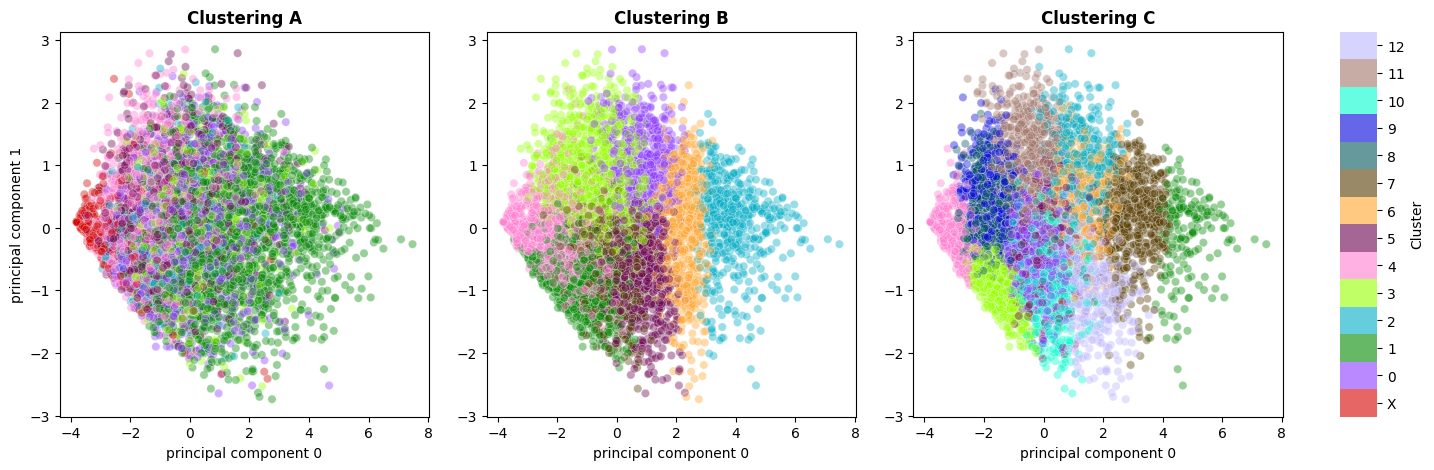

In [595]:
max_cluster_count = 14  # including -1 for noise
embedding_algo = 't-SNE'
alpha = 0.4 # for scatter plots

fig, ax = plt.subplots(1, 4, figsize=(17, 5), gridspec_kw={'width_ratios': [1, 1, 1, 0.1]})

norm = plt.Normalize(0, max_cluster_count, )
palette = sns.color_palette(cc.glasbey, n_colors=max_cluster_count)
cmap = ListedColormap(palette.as_hex())
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])

cluster_lists = [
    [c for c in leo_clusters.cluster],
    [c for c in chris_clusters.cluster] + [-1],
    [c for c in tessa_clusters.cluster] + [-1]
]
labels = ['A', 'B', 'C']
embedding_id = results_df.index[0]
# em = results[embedding_id ]['embedding']
em = pca_embedding

xmin = em[:,0].min()
xmax = em[:,0].max()
ymin = em[:,1].min()
ymax = em[:,1].max()

for i in range(3):
    
    # fix color mapping by to introducing -1 to clusterings B and C (not displayed)
    if i == 0:
        embedding = em
    else:
        embedding = np.append(em, [[xmin-10, ymin-10]], axis=0)
    
    sns.scatterplot(
        x=embedding[:, 0],
        y=embedding[:, 1],
        palette = palette,
        hue=cluster_lists[i],
        data=em,
        legend=None,
        ax=ax[i],
        alpha=alpha
        
    )
#     ax[i].set_xlabel('%s embedding dimension 0' % embedding_algo)
    ax[i].set_xlabel('principal component 0')

# ax[0].set_ylabel('%s embedding dimension 1' % embedding_algo)
ax[0].set_ylabel('principal component 1')
cbar = fig.colorbar(sm, cax=ax[3], orientation="vertical", alpha=alpha*1.5, label='Cluster')
offset = ax[3].get_ylim()[1] / (2 * max_cluster_count)
cbar.set_ticks(np.arange(0, max_cluster_count) + offset, labels=[str(l) if l != -1 else 'X' for l in range(-1,13)])
ax[3].set_frame_on(False)

ax[1].set_xlim(ax[0].get_xlim())
ax[1].set_ylim(ax[0].get_ylim())
ax[2].set_xlim(ax[0].get_xlim())
ax[2].set_ylim(ax[0].get_ylim())

ax[0].set_title('Clustering A', fontweight='bold')
ax[1].set_title('Clustering B', fontweight='bold')
ax[2].set_title('Clustering C', fontweight='bold')


In [463]:
# with open('./figs/embedding_tsne_sil_weighted.pickle', 'wb') as outfile:
#     pk.dump(em, outfile)

#### We now combine the scatter plot and the grouping heatmaps into a single figure:

In [16]:
groups_df = pd.read_csv('../clusterings/tessa/symptom_groups.csv')

In [17]:
sympdf = symptom_data

In [18]:
avg_scores_by_grouping = {}
def make_avg_scores_by_grouping(sympdf = sympdf, clustercol = 'cluster', groups_df=groups_df):
    for grouping in groups_df.group.unique():
        # calculat the average score for each symptom in the group for each cluster in 'cluster'
        keepcols = groups_df.loc[groups_df.group == grouping, 'symptom'].tolist()
        #print(keepcols)
        keepcols.append(clustercol)
        a = sympdf.loc[:, keepcols]
        avg = a.groupby(clustercol).mean()
        avg_scores_by_grouping[grouping] = avg.mean(axis=1)
        #avg = sympdf.loc[:, sympdf.columns.str.startswith(grouping)].groupby(clus).mean()
    return(pd.DataFrame(avg_scores_by_grouping))

In [19]:
sympdf['LCA'] = tessa_clusters.cluster
sympdf['Leo'] = leo_clusters.cluster
sympdf['Chris'] = chris_clusters.cluster

In [20]:
tessadf = make_avg_scores_by_grouping(clustercol = "LCA")

In [21]:
chrisdf = make_avg_scores_by_grouping(clustercol="Chris")

In [22]:
leodf = make_avg_scores_by_grouping(clustercol="Leo")

/tmp/ipykernel_22662/270281278.py:37: UserWarning: The palette list has more values (14) than needed (7), which may not be intended.
  sns.scatterplot(
/tmp/ipykernel_22662/270281278.py:37: UserWarning: The palette list has more values (14) than needed (9), which may not be intended.
  sns.scatterplot(


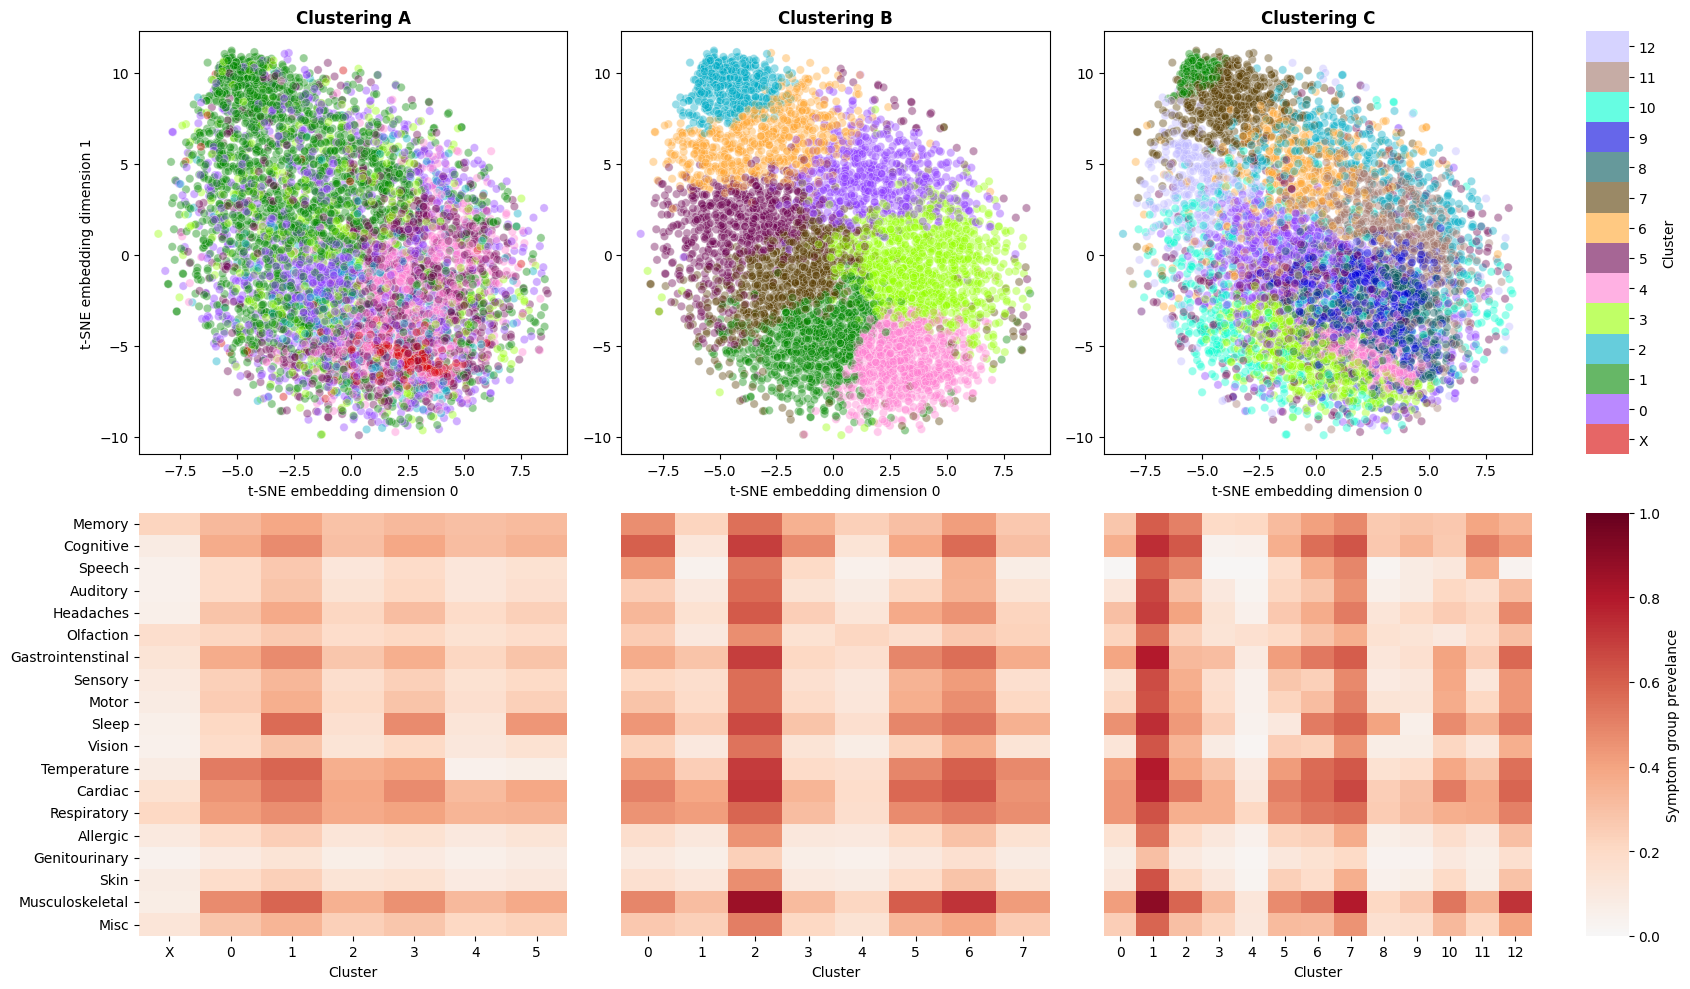

In [23]:
max_cluster_count = 14  # including -1 for noise
embedding_algo = 't-SNE'
alpha = 0.4 # for scatter plots

fig, ax = plt.subplots(2, 4, figsize=(17, 10), gridspec_kw={'width_ratios': [1, 1, 1, 0.1]})

norm = plt.Normalize(0, max_cluster_count, )
palette = sns.color_palette(cc.glasbey, n_colors=max_cluster_count)
cmap = ListedColormap(palette.as_hex())
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])

cluster_lists = [
    [c for c in leo_clusters.cluster],
#     hdb.labels_,
    [c for c in chris_clusters.cluster] + [-1],
    [c for c in tessa_clusters.cluster] + [-1]
]
labels = ['A', 'B', 'C']
embedding_id = results_df.index[0]
em = results[embedding_id ]['embedding']
# em = pca_embedding

xmin = em[:,0].min()
xmax = em[:,0].max()
ymin = em[:,1].min()
ymax = em[:,1].max()

for i in range(3):
    
    # fix color mapping by to introducing -1 to clusterings B and C (not displayed)
    if i == 0:
        embedding = em
    else:
        embedding = np.append(em, [[xmin-1, ymin-1]], axis=0)
    
    sns.scatterplot(
        x=embedding[:, 0],
        y=embedding[:, 1],
        palette = palette,
        hue=cluster_lists[i],
        data=em,
        legend=None,
        ax=ax[0,i],
        alpha=alpha
        
    )
    ax[0,i].set_xlabel('%s embedding dimension 0' % embedding_algo)


ax[0,0].set_ylabel('%s embedding dimension 1' % embedding_algo)
cbar = fig.colorbar(sm, cax=ax[0,3], orientation="vertical", alpha=alpha*1.5, label='Cluster')
offset = ax[0,3].get_ylim()[1] / (2 * max_cluster_count)
cbar.set_ticks(np.arange(0, max_cluster_count) + offset, labels=[str(l) if l != -1 else 'X' for l in range(-1,13)])
ax[0,3].set_frame_on(False)

ax[0,1].set_xlim(ax[0,0].get_xlim())
ax[0,1].set_ylim(ax[0,0].get_ylim())
ax[0,2].set_xlim(ax[0,0].get_xlim())
ax[0,2].set_ylim(ax[0,0].get_ylim())

ax[0,0].set_title('Clustering A', fontweight='bold')
ax[0,1].set_title('Clustering B', fontweight='bold')
ax[0,2].set_title('Clustering C', fontweight='bold')


data1 = data1
data2 = chrisdf.T
data3 = tessadf.T
data1.rename(columns={-1: 'X'}, inplace=True)

cmap = "RdBu_r"

# Plot the first heatmap using Seaborn
sns.heatmap(data1, cmap=cmap, ax=ax[1,0], center = 0, cbar=False, vmin=0, vmax=1)
ax[1,0].set_xlabel('Cluster')
# ax[1,0].set_ylabel('Y-axis')

# Plot the second heatmap using Seaborn
sns.heatmap(data2, cmap=cmap, ax=ax[1,1],center = 0 , cbar=False, vmin=0, vmax=1)
ax[1,1].set_xlabel('Cluster')
ax[1,1].set_yticks([])  # Remove y-axis ticks for shared y-axis

# Plot the third heatmap using Seaborn
sns.heatmap(
    data3, cmap=cmap, ax=ax[1,2], center=0, cbar_ax=ax[1,3], vmin=0, vmax=1, 
    cbar_kws={'label': 'Symptom group prevelance'}
)
ax[1,2].set_xlabel('Cluster')
ax[1,2].set_yticks([])  # Remove y-axis ticks for shared y-axis

plt.tight_layout()

In [473]:
# with open('./figs/embedding_tsne_sil_mean.pickle', 'wb') as outfile:
#     pk.dump(em, outfile)

#### We now use the embedding to visualise symptom count and the symtpom groupings:

In [584]:
symptom_data = load_symptom_data(run_configs[1]['data_path'])

In [585]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca_embedding = pca.fit_transform(symptom_data)

In [586]:
groups_df.symptom

0                        Symptom_Memory_short
1                         Symptom_Memory_long
2              Symptom_Memory_no_new_memories
3                 Symptom_Memory_forget_tasks
4                        Symptom_Memory_other
                        ...                  
156                         Symptom_Neuralgia
157                Symptom_Pain_burning_chest
158               Symptom_Eye_Vision_pink_eye
159         Symptom_Eye_Vision_bloodshot_eyes
160    Symptom_Eye_Vision_redness_outside_eye
Name: symptom, Length: 161, dtype: object

In [587]:
symptom_data.sum(axis=1) / len(symptom_data.columns)

3        0.135802
5        0.277778
6        0.197531
8        0.358025
9        0.320988
           ...   
14158    0.333333
14161    0.216049
14163    0.395062
14166    0.135802
14168    0.222222
Length: 6031, dtype: float64

In [588]:
grouped_means = symptom_data.transpose().reset_index().merge(
    groups_df, how='inner', left_on='index', right_on='symptom'
).set_index('index').drop(columns=['symptom']).groupby('group').mean().transpose()

grouped_means['Symptom count'] = symptom_data.sum(axis=1) / len(symptom_data.columns)

In [589]:
len(pca_embedding)

6031

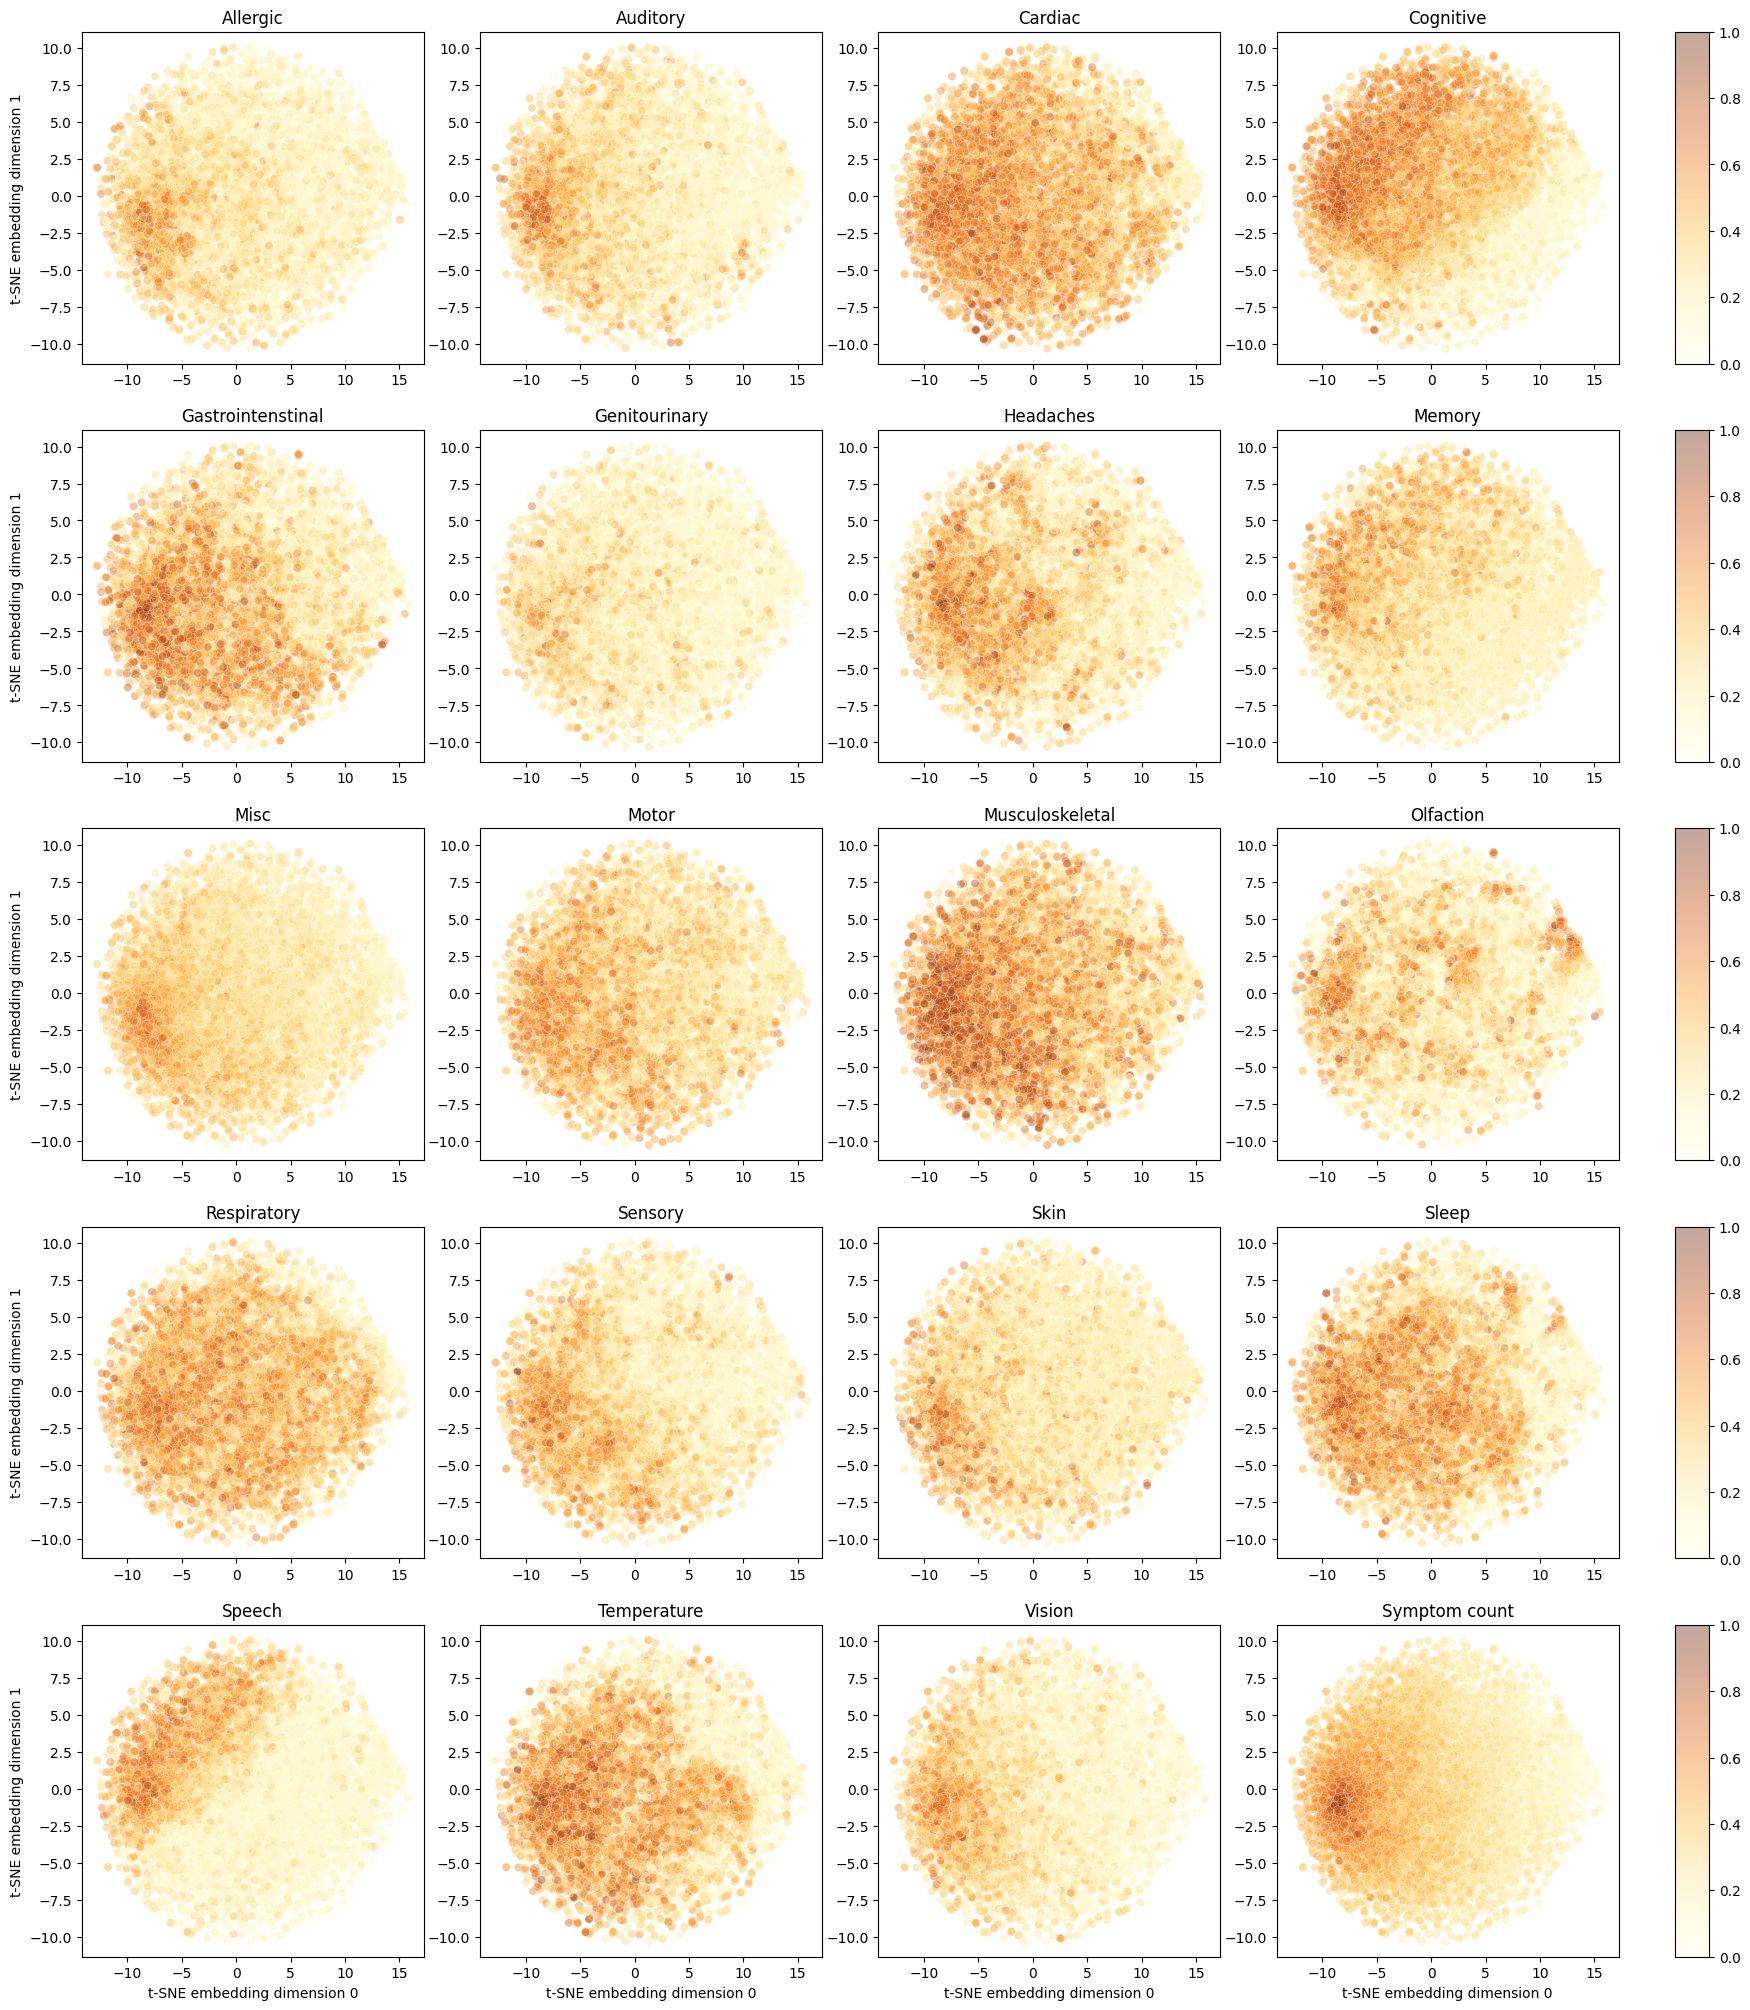

In [583]:
max_cluster_count = 14  # including -1 for noise
embedding_algo = 't-SNE'
alpha = 0.4 # for scatter plots

fig, ax = plt.subplots(5, 5, figsize=(21, 25), gridspec_kw={'width_ratios': [1, 1, 1, 1, 0.1]})

norm = plt.Normalize(0, 1)
sm = plt.cm.ScalarMappable(cmap='YlOrBr', norm=norm)
sm.set_array([])


labels = ['A', 'B', 'C']
embedding_id = results_df.index[0]
embedding = results[embedding_id ]['embedding']
# embedding = pca_embedding

xmin = em[:,0].min()
xmax = em[:,0].max()
ymin = em[:,1].min()
ymax = em[:,1].max()

for i,col in enumerate(grouped_means.columns):
    
    col_i = i % 4
    row_i = int(i / 4)
    sns.scatterplot(
        x=embedding[:, 0],
        y=embedding[:, 1],
        palette = sns.mpl_palette("YlOrBr", len(np.unique(grouped_means[col]))),
        hue=grouped_means[col],
        data=em,
        legend=None,
        ax=ax[row_i,col_i],
        alpha=alpha
        
    )
    ax[row_i, col_i].set_title(col)

for i in range(5):
    if i < 4:
        ax[4,i].set_xlabel('%s embedding dimension 0' % embedding_algo)

    cbar = fig.colorbar(sm, cax=ax[i,4], orientation="vertical", alpha=alpha) #, label='Cluster')
    ax[i,0].set_ylabel('%s embedding dimension 1' % embedding_algo)

In [481]:
from scipy.stats import pearsonr

In [491]:
correlation_df = pd.DataFrame(index=grouped_means.columns)

In [497]:
r_col_0 = []
r_col_1 = []

for col in grouped_means.columns:
    
    res = pearsonr(embedding[:,0], grouped_means[col])
    r_col_0.append('%.3f (%.3f)' % (res[0], res[1]))
#     p_col_0.append(res[1])
    
    res = pearsonr(embedding[:,1], grouped_means[col])
    r_col_1.append('%.3f (%.3f)' % (res[0], res[1]))
#     p_col_1.append(res[1])
    
correlation_df['r_dim_0'] = r_col_0
correlation_df['r_dim_1'] = r_col_1

In [498]:
correlation_df

r_dim_0        r_dim_1
group                                           
Allergic           -0.373 (0.000)  0.446 (0.000)
Auditory           -0.333 (0.000)  0.581 (0.000)
Cardiac            -0.479 (0.000)  0.525 (0.000)
Cognitive          -0.069 (0.000)  0.784 (0.000)
Gastrointenstinal  -0.505 (0.000)  0.482 (0.000)
Genitourinary      -0.260 (0.000)  0.344 (0.000)
Headaches          -0.351 (0.000)  0.544 (0.000)
Memory             -0.033 (0.011)  0.540 (0.000)
Misc               -0.570 (0.000)  0.602 (0.000)
Motor              -0.371 (0.000)  0.482 (0.000)
Musculoskeletal    -0.418 (0.000)  0.524 (0.000)
Olfaction          -0.098 (0.000)  0.286 (0.000)
Respiratory        -0.498 (0.000)  0.440 (0.000)
Sensory            -0.444 (0.000)  0.494 (0.000)
Skin               -0.314 (0.000)  0.357 (0.000)
Sleep              -0.408 (0.000)  0.518 (0.000)
Speech             -0.052 (0.000)  0.661 (0.000)
Temperature        -0.528 (0.000)  0.512 (0.000)
Vision             -0.393 (0.000)  0.596 (0.000)
Symptom count      -0.563 (0.000)  0.834 (0.000)

In [511]:
all_data = pd.read_csv(run_configs[1]['data_path'], index_col=0)
all_data.loc[all_data.Physical_PEM_Severity==0, 'Physical_PEM_Severity'] = np.nan
all_data.loc[all_data.Cognitive_PEM_Severity==0, 'Cognitive_PEM_Severity'] = np.nan

In [512]:
all_data['Physical_PEM_Severity'].isna().sum()

760

In [513]:
all_data['Cognitive_PEM_Severity'].isna().sum()

1312

In [514]:
pearsonr(grouped_means[~all_data['Physical_PEM_Severity'].isna()]['Symptom count'], all_data[~all_data['Physical_PEM_Severity'].isna()]['Physical_PEM_Severity'])

PearsonRResult(statistic=0.2610644287256918, pvalue=7.236996331846116e-83)

In [515]:
pearsonr(grouped_means[~all_data['Cognitive_PEM_Severity'].isna()]['Symptom count'], all_data[~all_data['Cognitive_PEM_Severity'].isna()]['Cognitive_PEM_Severity'])

PearsonRResult(statistic=0.35270826545142825, pvalue=2.763700063469303e-138)

In [525]:
nonna = ~(all_data['Cognitive_PEM_Severity'].isna() + all_data['Physical_PEM_Severity'].isna())

In [526]:
pearsonr(all_data[nonna]['Physical_PEM_Severity'], all_data[nonna]['Cognitive_PEM_Severity'])

PearsonRResult(statistic=0.34892500609579946, pvalue=9.089009252552288e-134)

#### Here we try clustering the consensus embedding:

In [353]:
from sklearn.cluster import HDBSCAN, KMeans

In [362]:
km = KMeans(n_clusters=10, random_state=42)

In [363]:
km.fit(embedding)

/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


KMeans(n_clusters=10, random_state=42)

In [364]:
len(km.labels_)

6031

In [441]:
hdb = HDBSCAN(min_cluster_size=100, min_samples=1, cluster_selection_epsilon=0.8)

In [442]:
hdb.fit(embedding)

HDBSCAN(cluster_selection_epsilon=0.8, min_cluster_size=100, min_samples=1)

In [443]:
np.unique(hdb.labels_, return_counts=True)

(array([-1,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13]),
 array([ 482,  178,  105,  554,  524,  464,  122,  745,  184,  243,  316,
         124,  390, 1325,  275]))

In [403]:
new_clusters = km.labels_

/tmp/ipykernel_9370/2465281948.py:30: UserWarning: The palette list has more values (14) than needed (10), which may not be intended.
  sns.scatterplot(
/tmp/ipykernel_9370/2465281948.py:30: UserWarning: 
The palette list has fewer values (14) than needed (15) and will cycle, which may produce an uninterpretable plot.
  sns.scatterplot(
/tmp/ipykernel_9370/2465281948.py:30: UserWarning: The palette list has more values (14) than needed (8), which may not be intended.
  sns.scatterplot(


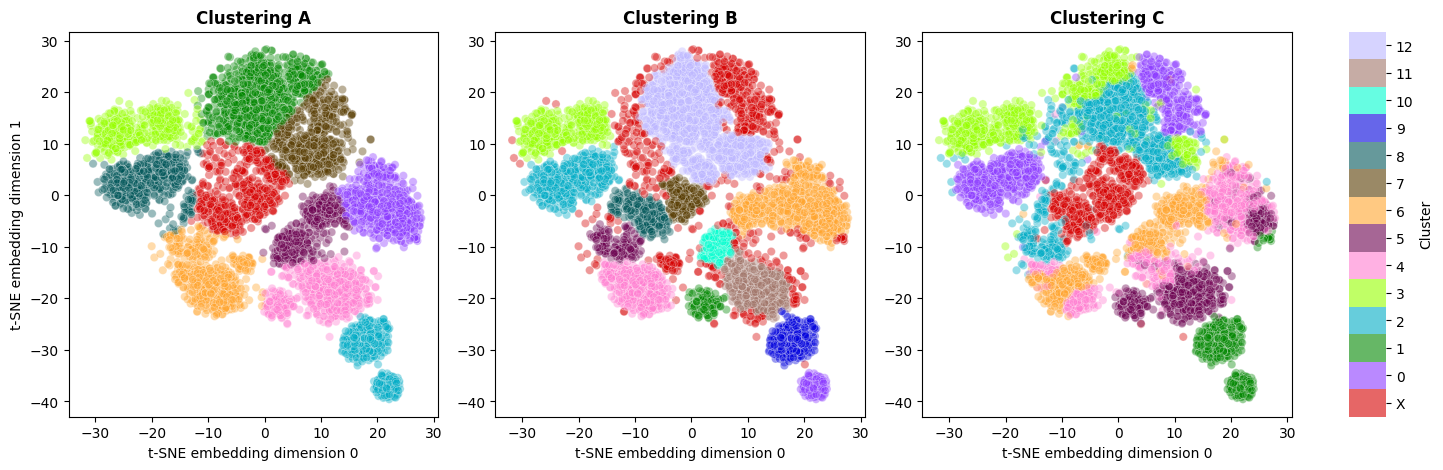

In [444]:
max_cluster_count = 14  # including -1 for noise
embedding_algo = 't-SNE'
alpha = 0.4 # for scatter plots

fig, ax = plt.subplots(1, 4, figsize=(17, 5), gridspec_kw={'width_ratios': [1, 1, 1, 0.1]})

norm = plt.Normalize(0, max_cluster_count, )
palette = sns.color_palette(cc.glasbey, n_colors=max_cluster_count)
cmap = ListedColormap(palette.as_hex())
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])

cluster_lists = [
    km.labels_,
    hdb.labels_,
    [c for c in chris_clusters.cluster],
#     [c for c in tessa_clusters.cluster]
]
labels = ['A', 'B', 'C']
embedding_id = results_df.index[0]
em = results[embedding_id ]['embedding']

xmin = em[:,0].min()
xmax = em[:,0].max()
ymin = em[:,1].min()
ymax = em[:,1].max()

for i in range(3):
    
    sns.scatterplot(
        x=embedding[:, 0],
        y=embedding[:, 1],
        palette = palette,
        hue=cluster_lists[i],
        data=em,
        legend=None,
        ax=ax[i],
        alpha=alpha
        
    )
    ax[i].set_xlabel('%s embedding dimension 0' % embedding_algo)


ax[0].set_ylabel('%s embedding dimension 1' % embedding_algo)
cbar = fig.colorbar(sm, cax=ax[3], orientation="vertical", alpha=alpha*1.5, label='Cluster')
offset = ax[3].get_ylim()[1] / (2 * max_cluster_count)
cbar.set_ticks(np.arange(0, max_cluster_count) + offset, labels=[str(l) if l != -1 else 'X' for l in range(-1,13)])
ax[3].set_frame_on(False)

ax[1].set_xlim(ax[0].get_xlim())
ax[1].set_ylim(ax[0].get_ylim())
ax[2].set_xlim(ax[0].get_xlim())
ax[2].set_ylim(ax[0].get_ylim())

ax[0].set_title('Clustering A', fontweight='bold')
ax[1].set_title('Clustering B', fontweight='bold')
ax[2].set_title('Clustering C', fontweight='bold');


#### Testing the parametric UMAP embedding:

In [6]:
from umap.parametric_umap import ParametricUMAP

In [9]:
SEARCH_TYPE = 'randomized_search'  # we want random parameterisations for diversity.
SAMPLE_SIZE = 200  # number of sample to take from each pipeline to build library 
RUN_IDS_TO_INCLUDE = [1, 2, 5, 6]  # we will reproduce using only kmeans (and including p-umap)
NMI_SCORE = 'mi'  # arg to pass to clustering_similarity method to use partial NMI (ignoring -1 labels from hdbscan) 
SEED = 42
IGNORE_LABEL = None

In [7]:
run_metadata = {
    'randomized_search': {
        13: {
            'run_path': 'rusty-chris/tune_shallow_clustering/runs/lo5r07or',
            'results_path': 'results/parametric_umap_kmeans_silhouette_run_10/all_results.pickle'
        },
        15: {
            'run_path': 'rusty-chris/tune_shallow_clustering/tv9hnbnn',
            'results_path': 'results/parametric_umap_hdbscan_silhouette_run_10/all_results.pickle'
        }
    }
}

In [10]:
for key in run_metadata[SEARCH_TYPE].keys():
    run_configs[key].update(run_metadata[SEARCH_TYPE][key])

In [11]:
def load_results(run_id):
    run_config = run_configs[run_id]
    with open(run_config['results_path'], 'rb') as outfile:
        results = pk.load(outfile)
        
    results = pd.DataFrame.from_dict(results, orient='index')
    results['original_index'] = results.index
    results['run_id'] = run_id
    return results

In [12]:
all_results = {
    run_id: load_results(run_id)
    for run_id in run_metadata[SEARCH_TYPE].keys()
}

In [14]:
all_results[13].loc[6]

best_score                                                                                         0.431936
best_params                                               {'kmeans__init': 'random', 'kmeans__n_clusters...
current_params                                            {'kmeans__init': 'random', 'kmeans__n_clusters...
silhouette                                                                                         0.394842
dbcv                                                                                                     -1
rv                                                                                                       -1
calinski_harabasz                                                                               6893.140542
davies_bouldin                                                                                     0.776751
dbcv_minkowski                                                                                    -0.644813
fraction_clustered          

#### Quick test for coginitive PEM and symtpom burden

In [528]:
c_sc= [
53,
30,
89,
34,
21,
54,
69,
40]
c_cpem=[0.739,
0.478,
0.786,
0.654,
0.479,
0.611,
0.736,
0.554]
c_ppem=[
0.806,
0.740,
0.876,
0.749,
0.676,
0.794,
0.848,
0.763]

In [542]:
l_sc=[
16,
44,
60,
35,
46,
28,
37]


l_cpem=[  
0.271,
0.549,
0.636,
0.485,
0.594,
0.480,
0.530]

l_ppem=[
0.619,
0.773,
0.811,
0.747,
0.773,
0.719,
0.735
]

In [539]:
t_sc=[
40,
101,
56,
27,
11,
44,
58,
78,
23,
24,
45,
38,
63]


t_cpem=[  
0.595,
0.818,
0.772,
0.416,
0.394,
0.593,
0.703,
0.757,
0.539,
0.574,
0.555,
0.682,
0.675]

t_ppem=[
0.758,
0.897,
0.811,
0.710,
0.667,
0.788,
0.825,
0.854,
0.742,
0.718,
0.759,
0.775,
0.822,
]

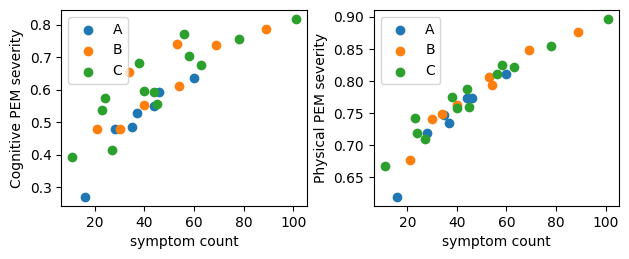

In [549]:

plt.subplot(2,2,1)
plt.scatter(l_sc, l_cpem, label='A')
plt.scatter(c_sc, c_cpem, label='B')
plt.scatter(t_sc, t_cpem, label='C')
plt.legend()
plt.xlabel('symptom count')
plt.ylabel('Cognitive PEM severity')

plt.subplot(2,2,2)
plt.scatter(l_sc, l_ppem, label='A')
plt.scatter(c_sc, c_ppem, label='B')
plt.scatter(t_sc, t_ppem, label='C')
plt.legend()
plt.xlabel('symptom count')
plt.ylabel('Physical PEM severity')

plt.tight_layout()

In [534]:
pearsonr(t_sc, t_cpem)

PearsonRResult(statistic=0.8650215536745807, pvalue=0.00013455367067573246)

In [535]:
pearsonr(l_sc, l_cpem)

PearsonRResult(statistic=0.9373062179379485, pvalue=0.0018271349759493736)

In [536]:
pearsonr(c_sc, c_cpem)

PearsonRResult(statistic=0.8634805420622628, pvalue=0.00572746012590889)

In [538]:
pearsonr(c_sc, c_ppem)

PearsonRResult(statistic=0.9714771322891612, pvalue=5.677830455049471e-05)

In [541]:
pearsonr(t_sc, t_ppem)

PearsonRResult(statistic=0.9684868570189831, pvalue=5.527645685894657e-08)

In [543]:
pearsonr(l_sc, l_ppem)

PearsonRResult(statistic=0.9505569310417671, pvalue=0.0010165201101280665)

In [ ]:
plt.scatter(c_ppem, c_cpem)

In [ ]:
plt.scatter(range(8), np.array(c_cpem) / np.array(c_ppem) )

#### We test out kn imputation of missing labels - what k to use?

In [37]:
def impute_labels(cluster_assignment_dict, symptom_data, knn_impute=False, k=3):
    """
    Method to impute missing labels when patient labelling is incomplete (e.g. when subsampling for robustness
    or when hdbscan labels a patient as -1.)
    
    Default behaviour is to just fill the missing labels with -1 (consistent with hdbscan).
    The alternative, when knn_impute=True is to train a KNN-classifier and use it to predict the 
    missing labels.
    
    Note: 
    
    Args:
        cluster_assignment_dict (dict): an incomplete cluster assignment where keys 
                                        are the patient index from the original (symptom) 
                                        dataframe, and values are the cluster label for that
                                        patient.
                                        
        symptom_data (pandas.DataFrame): the original dataset with only symptom columns retained.
        
        knn_impute (bool): flag, whether to use knn to impute missing labels or just fill with -1
        k (int): number of neighbours for knn-impupter
    """
    
    if knn_impute:
        from sklearn.neighbors import KNeighborsClassifier

        imputer = KNeighborsClassifier(n_neighbors=k)
        imputer.fit(
            symptom_data.loc[cluster_assignment_dict.keys()], 
            list(cluster_assignment_dict.values())
        )

        def impute(patient_symptom_data, imputer=imputer):
            return int(imputer.predict(patient_symptom_data))
        
    else:
        def impute(patient_symptom_data):
            return -1
        
    return [
        cluster_assignment_dict.get(i, impute(symptom_data.loc[i].to_numpy().reshape(1, -1))) 
        for i in symptom_data.index
    ]

In [38]:
def create_imputed_labels(lib, symptom_data, knn_impute=False, k=3):
    
    imputed_labels = []
    
    for i in range(len(lib)):
        print(i)
        cluster_assignment_dict = dict(zip(
            library.iloc[i].patient_sample_index, library.iloc[i].labels
        ))
        imputed_labels.append(impute_labels(cluster_assignment_dict, symptom_data, knn_impute, k))  
        break
    return imputed_labels

In [39]:
s = chris_clusters.sample(frac=0.8)

In [40]:
library = pd.DataFrame(index=[1])

In [41]:
library['patient_sample_index'] = [s.index]

In [42]:
library['labels'] = [list(s.cluster)]

In [43]:
# library.iloc[0].labels

In [ ]:
ami_impute = []
for ki in range(5,200, 5):
    lib = library.copy()
    imputed_labels = create_imputed_labels(lib, symptom_data, knn_impute=True, k=ki)
    ami_impute.append(adjusted_mutual_info_score(chris_clusters.cluster, imputed_labels[0]))

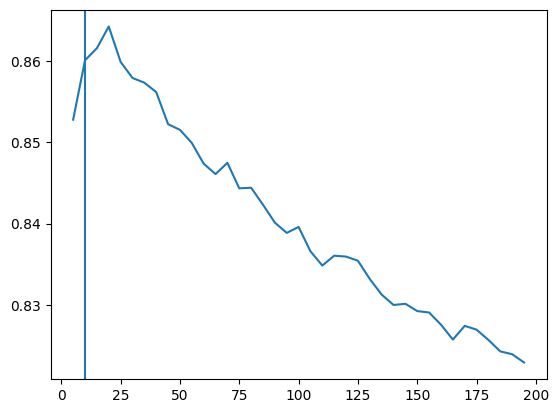

In [47]:
plt.plot(list(range(5,200, 5)), ami_impute)
plt.axvline(10)

In [ ]:
ami_impute = []
for ki in [3,4,5]:
    lib = library.copy()
    imputed_labels = create_imputed_labels(lib, symptom_data, knn_impute=True, k=ki)
    ami_impute.append(adjusted_mutual_info_score(chris_clusters.cluster, imputed_labels[0]))

In [49]:
ami_impute

[0.8368184703316531, 0.8457477991886211, 0.8527964358376648]